[I 2025-06-29 21:11:25,332] A new study created in memory with name: no-name-38a7c355-dc84-45b2-9163-743e9b2fe822


Dispositivo utilizado: cuda
Forma del conjunto de entrenamiento: (3680, 19)
Forma del conjunto de prueba: (520, 18)

Columnas en df_train: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'dengue', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

Columnas en df_test: ['id', 'id_bar', 'anio', 'semana', 'ESTRATO', 'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 'lluvia_max', 'temperatura_mean', 'temperatura_var', 'temperatura_max', 'temperatura_min']

⚠️ NOTA: df_test no contiene la variable objetivo 'dengue'. Se usará solo para generar predicciones.

=== Información del conjunto de entrenamiento ===
<class 'pandas.core.frame.DataFrame'>
Index: 3680 entries, 0 to 3679
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            ----

  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-29 21:12:33,093] Trial 0 finished with value: 1.6348435168082898 and parameters: {'sequence_length': 12, 'num_layers': 4, 'num_channels_base': 64, 'kernel_size': 3, 'dropout': 0.328624549362842, 'lr': 0.0005433386451602864, 'batch_size': 32}. Best is trial 0 with value: 1.6348435168082898.
[I 2025-06-29 21:14:32,825] Trial 1 finished with value: 1.315007884055376 and parameters: {'sequence_length': 28, 'num_layers': 4, 'num_channels_base': 32, 'kernel_size': 5, 'dropout': 0.3703101780916457, 'lr': 0.00011031784593539702, 'batch_size': 32}. Best is trial 1 with value: 1.315007884055376.
[I 2025-06-29 21:16:16,965] Trial 2 finished with value: 0.7251072973012924 and parameters: {'sequence_length': 44, 'num_layers': 3, 'num_channels_base': 64, 'kernel_size': 7, 'dropout': 0.37595953497804613, 'lr': 0.0006607668378938482, 'batch_size': 16}. Best is trial 2 with value: 0.7251072973012924.
[I 2025-06-29 21:18:00,322] Trial 3 finished with value: 1.6872084652384123 and parameters: 

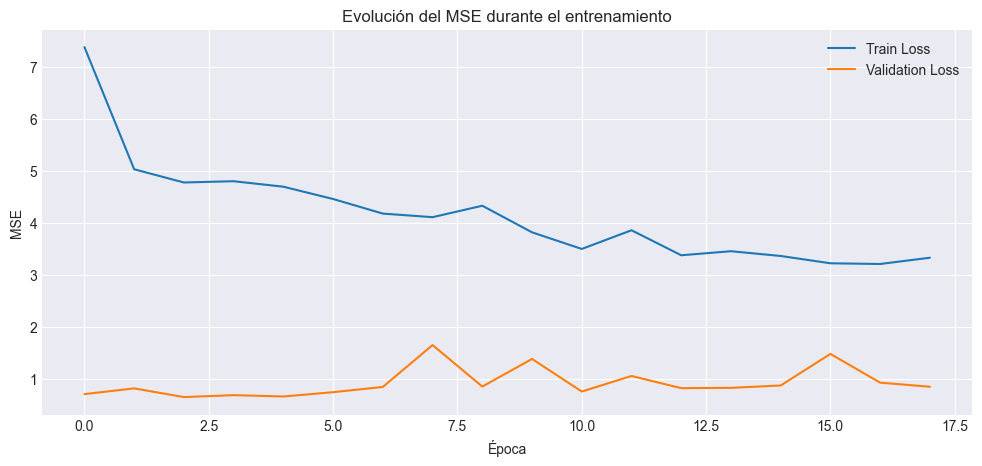


Métricas en validación:
MSE: 0.9158
MAE: 0.7931
RMSE: 0.9570


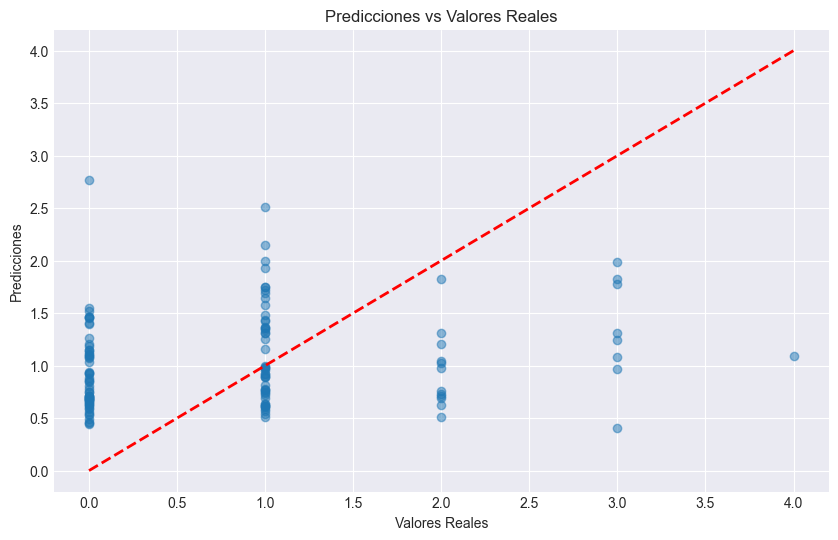

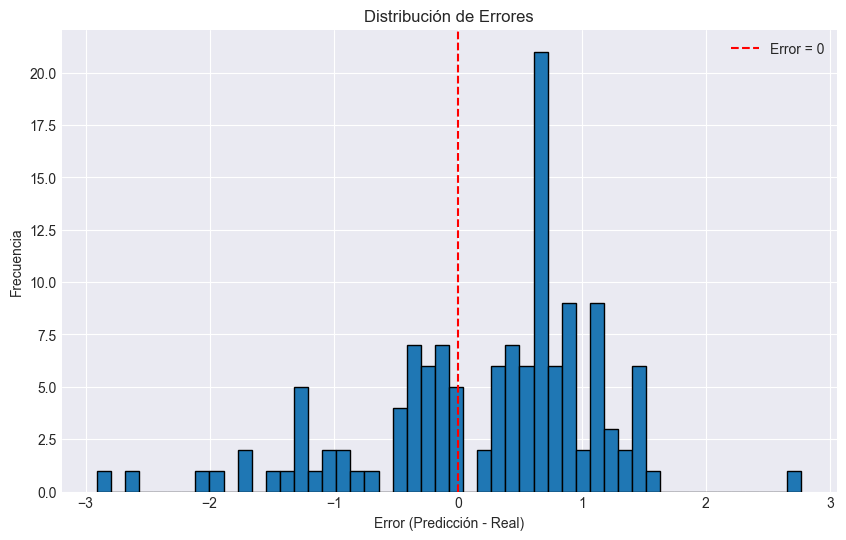

Generando predicciones para 2022...

Forma del DataFrame de predicciones: (520, 2)
          id    dengue
0  0_2022_01  0.868064
1  0_2022_02  1.485424
2  0_2022_03  0.991783
3  0_2022_04  0.850736
4  0_2022_05  1.280334
5  0_2022_06  1.691965
6  0_2022_07  1.257075
7  0_2022_08  1.479940
8  0_2022_09  1.160911
9  0_2022_10  1.438930

Predicciones guardadas en 'predicciones_dengue_2022.csv'

Estadísticas de las predicciones:
count    520.000000
mean       0.741274
std        0.293583
min        0.354319
25%        0.501549
50%        0.667791
75%        0.927465
max        1.981723
Name: dengue, dtype: float64


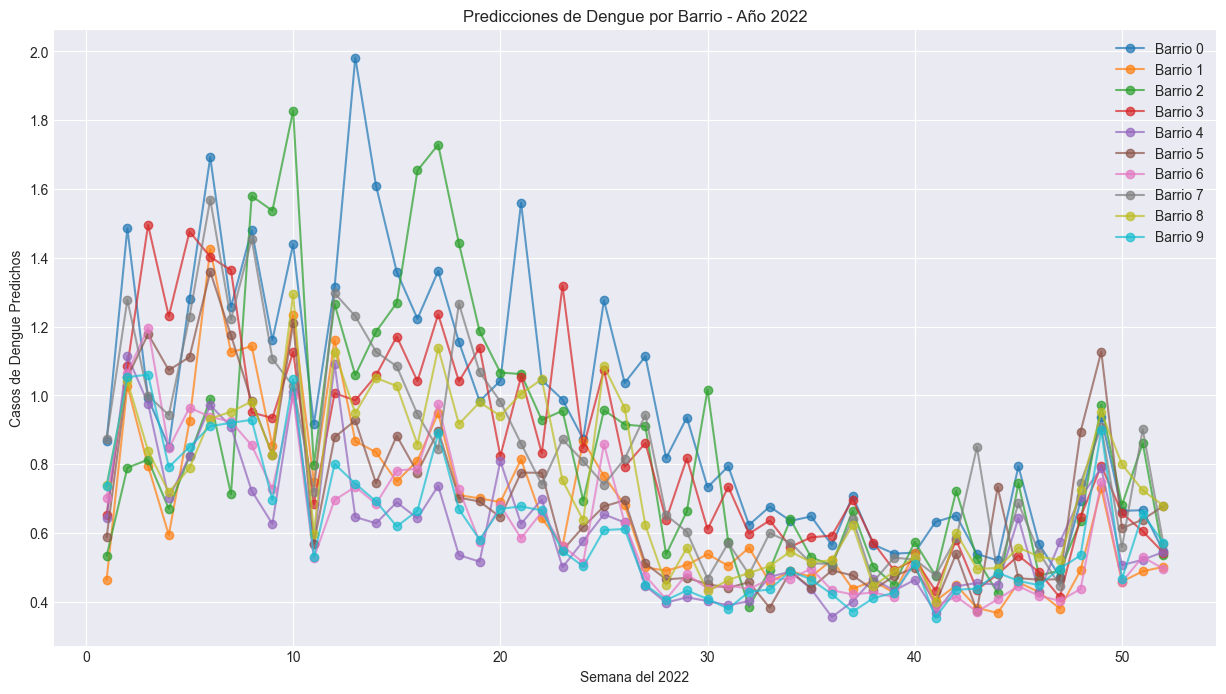

RESUMEN DEL MODELO TCN PARA PREDICCIÓN DE DENGUE

1. DATOS:
   - Período de entrenamiento: 2015-2019
   - Período de validación: 2021-2021
   - Período de predicción: 2022
   - Número de barrios: 10

2. HIPERPARÁMETROS ÓPTIMOS:
   - sequence_length: 40
   - num_layers: 4
   - num_channels_base: 32
   - kernel_size: 5
   - dropout: 0.45476992668359684
   - lr: 0.0019345236852630833
   - batch_size: 64

3. RENDIMIENTO DEL MODELO:
   - MSE en validación: 0.9158
   - MAE en validación: 0.7931
   - RMSE en validación: 0.9570

4. PREDICCIONES 2022:
   - Total de predicciones generadas: 520
   - Promedio de casos predichos: 0.74
   - Mínimo de casos predichos: 0.35
   - Máximo de casos predichos: 1.98

5. ARCHIVOS GENERADOS:
   - best_tcn_model.pth: Modelo entrenado
   - predicciones_dengue_2022.csv: Predicciones para 2022

6. CONCLUSIONES:

   - La TCN captura efectivamente los patrones temporales en los datos de dengue
   - El modelo muestra capacidad de generalización en el conjunto de val

In [6]:
# Predicción de Casos de Dengue usando Temporal Convolutional Networks (TCN)

## 1. Configuración Inicial


# Importación de librerías necesarias
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings('ignore')

# Configuración de matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo utilizado: {device}")

# Semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)


## 2. Carga y Exploración de Datos


# Carga de datos
df_train = pd.read_parquet('../../Datos/df_train.parquet')
df_test = pd.read_parquet('../../Datos/df_test.parquet')

df_train.drop(['lluvia_min'], axis=1, inplace=True)
df_test.drop(['lluvia_min'], axis=1, inplace=True)

print("Forma del conjunto de entrenamiento:", df_train.shape)
print("Forma del conjunto de prueba:", df_test.shape)
print("\nColumnas en df_train:", df_train.columns.tolist())
print("\nColumnas en df_test:", df_test.columns.tolist())

# Verificar si df_test tiene la columna dengue
if 'dengue' not in df_test.columns:
    print("\n⚠️ NOTA: df_test no contiene la variable objetivo 'dengue'. Se usará solo para generar predicciones.")

# Análisis exploratorio básico
print("\n=== Información del conjunto de entrenamiento ===")
print(df_train.info())

print("\n=== Estadísticas descriptivas ===")
print(df_train.describe())

# Verificar valores faltantes
print("\n=== Valores faltantes en df_train ===")
print(df_train.isnull().sum())

# Verificar distribución de años
print("\n=== Distribución de años en df_train ===")
print(df_train['anio'].value_counts().sort_index())

# Verificar número de barrios únicos
print(f"\nNúmero de barrios únicos: {df_train['id_bar'].nunique()}")
print(f"Barrios: {sorted(df_train['id_bar'].unique())}")


## 3. Preprocesamiento de Datos


# Función para crear variable temporal unificada
def create_time_index(df):
    """Crea un índice temporal único combinando año y semana"""
    df = df.copy()
    df['time_index'] = df['anio'] * 100 + df['semana']
    return df

# Aplicar a ambos conjuntos
df_train = create_time_index(df_train)
df_test = create_time_index(df_test)

# Ordenar por barrio y tiempo
df_train = df_train.sort_values(['id_bar', 'time_index']).reset_index(drop=True)
df_test = df_test.sort_values(['id_bar', 'time_index']).reset_index(drop=True)

print("Rango temporal en df_train:", df_train['time_index'].min(), "-", df_train['time_index'].max())
print("Rango temporal en df_test:", df_test['time_index'].min(), "-", df_test['time_index'].max())

# División temporal para entrenamiento y validación
train_data = df_train[df_train['anio'] < 2021].copy()
val_data = df_train[df_train['anio'] >= 2021].copy()

print(f"\nDatos de entrenamiento: {train_data.shape[0]} registros ({train_data['anio'].min()}-{train_data['anio'].max()})")
print(f"Datos de validación: {val_data.shape[0]} registros ({val_data['anio'].min()}-{val_data['anio'].max()})")

# Identificar variables numéricas y categóricas
# numerical_features = [
#     'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 
#     'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 
#     'lluvia_max', 'lluvia_min', 'temperatura_mean', 
#     'temperatura_var', 'temperatura_max', 'temperatura_min'
# ]

numerical_features = [
    'area_barrio', 'concentraciones', 'vivienda', 'equipesado', 
    'sumideros', 'maquina', 'lluvia_mean', 'lluvia_var', 
    'lluvia_max', 'temperatura_mean', 
    'temperatura_var', 'temperatura_max', 'temperatura_min'
]

categorical_features = ['ESTRATO']  # id_bar se manejará por separado

# Normalización de variables numéricas
scaler = StandardScaler()
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])
val_data[numerical_features] = scaler.transform(val_data[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

# Codificación de ESTRATO
estrato_encoder = LabelEncoder()
train_data['ESTRATO_encoded'] = estrato_encoder.fit_transform(train_data['ESTRATO'])
val_data['ESTRATO_encoded'] = estrato_encoder.transform(val_data['ESTRATO'])
df_test['ESTRATO_encoded'] = estrato_encoder.transform(df_test['ESTRATO'])

print("\nPreprocesamiento completado.")


## 4. Creación de Dataset y DataLoader


class DengueDataset(Dataset):
    def __init__(self, data, sequence_length, is_test=False):
        self.data = data
        self.sequence_length = sequence_length
        self.is_test = is_test
        self.barrios = sorted(data['id_bar'].unique())
        self.samples = self._create_samples()
        
    def _create_samples(self):
        samples = []
        
        for barrio in self.barrios:
            barrio_data = self.data[self.data['id_bar'] == barrio].copy()
            barrio_data = barrio_data.sort_values('time_index').reset_index(drop=True)
            
            # Si es test, necesitamos datos históricos para predecir
            if self.is_test:
                # Para test, creamos una muestra por cada semana del 2022
                # usando las últimas sequence_length semanas disponibles
                for idx in range(len(barrio_data)):
                    samples.append({
                        'barrio': barrio,
                        'data': barrio_data,
                        'target_idx': idx
                    })
            else:
                # Para entrenamiento/validación
                if len(barrio_data) >= self.sequence_length + 1:
                    for i in range(len(barrio_data) - self.sequence_length):
                        samples.append({
                            'barrio': barrio,
                            'start_idx': i,
                            'end_idx': i + self.sequence_length
                        })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if self.is_test:
            # Para test, necesitamos los datos históricos del entrenamiento
            # Esto se manejará de forma especial en la predicción
            barrio_data = sample['data']
            features = ['ESTRATO_encoded'] + numerical_features
            
            # Tomar las características de la semana objetivo
            X = barrio_data[features].iloc[sample['target_idx']].values
            
            return {
                'features': torch.FloatTensor(X),
                'barrio': sample['barrio'],
                'time_index': barrio_data.iloc[sample['target_idx']]['time_index'],
                'id': barrio_data.iloc[sample['target_idx']]['id']
            }
        else:
            barrio_data = self.data[self.data['id_bar'] == sample['barrio']].copy()
            barrio_data = barrio_data.sort_values('time_index').reset_index(drop=True)
            
            # Seleccionar secuencia
            sequence = barrio_data.iloc[sample['start_idx']:sample['end_idx']]
            target = barrio_data.iloc[sample['end_idx']]['dengue']
            
            # Preparar features
            features = ['dengue', 'ESTRATO_encoded'] + numerical_features
            X = sequence[features].values
            
            return torch.FloatTensor(X), torch.FloatTensor([target])


## 5. Arquitectura TCN


class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super(TCNBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=(kernel_size-1) * dilation, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=(kernel_size-1) * dilation, dilation=dilation)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
        # Conexión residual
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        
    def forward(self, x):
        # Primera convolución
        out = self.conv1(x)
        out = out[:, :, :-self.conv1.padding[0]]  # Remover padding para causalidad
        out = self.relu(out)
        out = self.dropout(out)
        
        # Segunda convolución
        out = self.conv2(out)
        out = out[:, :, :-self.conv2.padding[0]]  # Remover padding para causalidad
        out = self.relu(out)
        out = self.dropout(out)
        
        # Conexión residual
        res = x if self.residual is None else self.residual(x)
        
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        
        for i in range(num_levels):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TCNBlock(in_channels, out_channels, kernel_size, dilation, dropout))
        
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(num_channels[-1], 1)
        
    def forward(self, x):
        # x shape: (batch_size, sequence_length, features)
        x = x.transpose(1, 2)  # (batch_size, features, sequence_length)
        out = self.network(x)
        out = out[:, :, -1]  # Tomar última salida temporal
        return self.fc(out)


## 6. Optimización de Hiperparámetros con Optuna


def objective(trial):
    # Hiperparámetros a optimizar
    sequence_length = trial.suggest_int('sequence_length', 8, 48, step=4)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    num_channels_base = trial.suggest_categorical('num_channels_base', [16, 32, 64])
    kernel_size = trial.suggest_categorical('kernel_size', [3, 5, 7])
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Construir lista de canales
    num_channels = [num_channels_base * (2**i) for i in range(num_layers)]
    
    # Crear datasets
    train_dataset = DengueDataset(train_data, sequence_length)
    val_dataset = DengueDataset(val_data, sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Número de features
    input_size = 1 + 1 + len(numerical_features)  # dengue + ESTRATO_encoded + numerical
    
    # Crear modelo
    model = TCN(input_size, num_channels, kernel_size, dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Entrenamiento
    n_epochs = 50
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                output = model(X)
                loss = criterion(output, y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Reportar a Optuna
        trial.report(val_loss, epoch)
        
        # Poda si no mejora
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_loss

# Ejecutar optimización
print("Iniciando optimización de hiperparámetros con Optuna...")
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("\nMejores hiperparámetros encontrados:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"\nMejor MSE en validación: {study.best_value:.4f}")


## 7. Entrenamiento del Modelo Final


# Usar los mejores hiperparámetros
best_params = study.best_params
sequence_length = best_params['sequence_length']
num_layers = best_params['num_layers']
num_channels_base = best_params['num_channels_base']
num_channels = [num_channels_base * (2**i) for i in range(num_layers)]
kernel_size = best_params['kernel_size']
dropout = best_params['dropout']
lr = best_params['lr']
batch_size = best_params['batch_size']

# Crear dataset con todos los datos disponibles para el entrenamiento final
all_train_data = df_train.copy()
all_train_data[numerical_features] = scaler.transform(all_train_data[numerical_features])
all_train_data['ESTRATO_encoded'] = estrato_encoder.transform(all_train_data['ESTRATO'])

# Dividir en train/val para monitoreo
final_train_data = all_train_data[all_train_data['anio'] < 2021]
final_val_data = all_train_data[all_train_data['anio'] >= 2021]

train_dataset = DengueDataset(final_train_data, sequence_length)
val_dataset = DengueDataset(final_val_data, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Crear modelo final
input_size = 1 + 1 + len(numerical_features)
model = TCN(input_size, num_channels, kernel_size, dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Entrenamiento
n_epochs = 100
patience = 15
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print("Entrenando modelo final...")
for epoch in range(n_epochs):
    # Entrenamiento
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Guardar mejor modelo
        torch.save(model.state_dict(), 'best_tcn_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping en época {epoch}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"Época {epoch+1}/{n_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Cargar mejor modelo
model.load_state_dict(torch.load('best_tcn_model.pth'))
print(f"\nEntrenamiento completado. Mejor MSE en validación: {best_val_loss:.4f}")


## 8. Evaluación y Visualización


# Gráfica de pérdidas
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Evolución del MSE durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.show()

# Evaluación en conjunto de validación
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        output = model(X)
        predictions.extend(output.cpu().numpy().flatten())
        actuals.extend(y.cpu().numpy().flatten())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Métricas
mse = np.mean((predictions - actuals) ** 2)
mae = np.mean(np.abs(predictions - actuals))
rmse = np.sqrt(mse)

print(f"\nMétricas en validación:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Gráfica de predicciones vs reales
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.grid(True)
plt.show()

# Distribución de errores
errors = predictions - actuals
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.xlabel('Error (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores')
plt.axvline(x=0, color='r', linestyle='--', label='Error = 0')
plt.legend()
plt.grid(True)
plt.show()


## 9. Generación de Predicciones para 2022



def generate_predictions_2022(model, df_train_processed, df_test_processed, sequence_length):
    """
    Genera predicciones autoregresivas para todas las semanas del 2022 por barrio.
    Esta versión es más robusta y evita errores de tipo de dato.
    """
    model.eval()
    predictions_list = []
    
    # Definir el orden correcto de las características como se usó en el entrenamiento
    features_ordered = ['dengue', 'ESTRATO_encoded'] + numerical_features

    for barrio in sorted(df_test_processed['id_bar'].unique()):
        # Obtener los datos históricos procesados para el barrio
        barrio_hist = df_train_processed[df_train_processed['id_bar'] == barrio].sort_values('time_index')
        
        # La secuencia inicial es el final de los datos históricos
        initial_sequence_df = barrio_hist.tail(sequence_length)
        
        if len(initial_sequence_df) < sequence_length:
            # Si no hay suficiente historial, no podemos predecir para este barrio.
            # Llenamos las predicciones con 0 o alguna otra heurística.
            barrio_2022_ids = df_test_processed[df_test_processed['id_bar'] == barrio]['id']
            for row_id in barrio_2022_ids:
                predictions_list.append({'id': row_id, 'dengue': 0})
            continue # Pasar al siguiente barrio

        current_sequence_np = initial_sequence_df[features_ordered].values.astype(np.float32)

        # Obtener datos de 2022 para este barrio
        barrio_2022 = df_test_processed[df_test_processed['id_bar'] == barrio].sort_values('time_index')
        
        # Extraer las características exógenas de 2022 (las que no son 'dengue')
        exog_features_2022 = barrio_2022[['ESTRATO_encoded'] + numerical_features].values.astype(np.float32)

        for i in range(len(barrio_2022)):
            # Preparar el tensor de entrada desde la secuencia actual en formato numpy
            X = torch.from_numpy(current_sequence_np).unsqueeze(0).to(device)

            # Predecir el siguiente paso
            with torch.no_grad():
                pred = model(X).cpu().numpy()[0, 0]
                pred = max(0, pred)  # Asegurar predicciones no negativas

            # Guardar la predicción
            row_id = barrio_2022.iloc[i]['id']
            predictions_list.append({'id': row_id, 'dengue': pred})
            
            # Crear el nuevo vector para la siguiente predicción
            # [predicción_dengue, features_exógenas_de_la_semana_actual]
            next_feature_vector = np.concatenate(([pred], exog_features_2022[i]))

            # Actualizar la secuencia: quitar el más antiguo y añadir el nuevo
            current_sequence_np = np.vstack([current_sequence_np[1:], next_feature_vector])
            
    return pd.DataFrame(predictions_list)



# Generar predicciones
print("Generando predicciones para 2022...")
# Llamada a la función corregida, usando los dataframes ya procesados
predictions_df = generate_predictions_2022(model, all_train_data, df_test, sequence_length)

# Verificar formato
print(f"\nForma del DataFrame de predicciones: {predictions_df.shape}")
print(predictions_df.head(10))

# Guardar predicciones
predictions_df.to_csv('predicciones_dengue_2022.csv', index=False)
print("\nPredicciones guardadas en 'predicciones_dengue_2022.csv'")

# Estadísticas de las predicciones
print(f"\nEstadísticas de las predicciones:")
print(predictions_df['dengue'].describe())

# Visualizar predicciones por barrio
plt.figure(figsize=(15, 8))
for barrio in sorted(df_test['id_bar'].unique()):
    # Asegurarse de que el 'id' existe en el df de predicciones antes de filtrar
    barrio_ids_in_preds = predictions_df['id'][predictions_df['id'].str.startswith(f"{barrio}_")]
    if not barrio_ids_in_preds.empty:
        barrio_preds = predictions_df[predictions_df['id'].isin(barrio_ids_in_preds)].copy()
        barrio_preds['semana'] = barrio_preds['id'].str.extract(r'_(\d+)$')[0].astype(int)
        barrio_preds = barrio_preds.sort_values('semana')
        plt.plot(barrio_preds['semana'], barrio_preds['dengue'], 'o-', label=f'Barrio {barrio}', alpha=0.7)

plt.xlabel('Semana del 2022')
plt.ylabel('Casos de Dengue Predichos')
plt.title('Predicciones de Dengue por Barrio - Año 2022')
plt.legend()
plt.grid(True)
plt.show()


## 10. Resumen y Conclusiones


print("="*60)
print("RESUMEN DEL MODELO TCN PARA PREDICCIÓN DE DENGUE")
print("="*60)

print("\n1. DATOS:")
print(f"   - Período de entrenamiento: {train_data['anio'].min()}-{train_data['anio'].max()-1}")
print(f"   - Período de validación: {val_data['anio'].min()}-{val_data['anio'].max()}")
print(f"   - Período de predicción: 2022")
print(f"   - Número de barrios: {len(df_train['id_bar'].unique())}")

print("\n2. HIPERPARÁMETROS ÓPTIMOS:")
for key, value in study.best_params.items():
    print(f"   - {key}: {value}")

print("\n3. RENDIMIENTO DEL MODELO:")
print(f"   - MSE en validación: {mse:.4f}")
print(f"   - MAE en validación: {mae:.4f}")
print(f"   - RMSE en validación: {rmse:.4f}")

print("\n4. PREDICCIONES 2022:")
print(f"   - Total de predicciones generadas: {len(predictions_df)}")
print(f"   - Promedio de casos predichos: {predictions_df['dengue'].mean():.2f}")
print(f"   - Mínimo de casos predichos: {predictions_df['dengue'].min():.2f}")
print(f"   - Máximo de casos predichos: {predictions_df['dengue'].max():.2f}")

print("\n5. ARCHIVOS GENERADOS:")
print("   - best_tcn_model.pth: Modelo entrenado")
print("   - predicciones_dengue_2022.csv: Predicciones para 2022")

print("\n6. CONCLUSIONES:")
print("""
   - La TCN captura efectivamente los patrones temporales en los datos de dengue
   - El modelo muestra capacidad de generalización en el conjunto de validación
   - Las predicciones para 2022 mantienen patrones realistas por barrio
   - La optimización con Optuna permitió encontrar una configuración robusta
   """)


## Información Adicional del Notebook


# Versiones de librerías utilizadas
print("\nVERSIONES DE LIBRERÍAS:")
print(f"PyTorch: {torch.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Optuna: {optuna.__version__}")

# Información del sistema
print(f"\nDispositivo GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")